## Text classification using Neural Networks
\
by:
**Anirudh Rayasam**

--------------------------------------------------------------------------------------------------------------------

In this solution, we try to classify documents from the Reuters Corpus dataset, based on the BIP Topic (Label). We begin with extracting and cleaning the data, followed by building classification models using general Machine Learning methods as well as Artificial Neural Networks.

- We begin with extracting the pre-processing the data using different techniques.
- We, then, convert our text data into numericals using Bag of Words (CountVectorizer) method.
- Clustering is performed just to form clusters in the given data so that we can have multiple different mini-datasets with similar articles to work on. 
- We chose to do K-Means without considering the known label, and have then evaluated our clusters using Silhouette score and other methods. Further, dimensionality reduction has also been performed due to a high volume of features.
- We re-append the labels to records in each cluster and go ahead with splitting the data into training and testing data. GridSearch Cross-validation has been used in this case, and the data splitting has been evaluated.
- A classification model for each cluster with significant data is built using OnevsRestClassifier as we're dealing with multi-class, multi-label data.
- The machine learning model has given an average accuracy of 40%.

- We enhance the feature extraction method using Artificial Neural Networks (Autoencoders and Convolutional Neural Networks). 
- With different logically placed dense layers, the neural networks achieve a classification accuracy of around 98%.



### Data set-up
 

**Extracting the information from the zipped files.**

In [0]:
#Unzipping the main 'Data' zip file with the help of zipfile library
import zipfile,fnmatch,os
import fnmatch,os
import glob
import os
from bs4 import BeautifulSoup
import csv
import pandas as pd
from zipfile import ZipFile

with ZipFile('Data.zip', 'r') as zipFolder:
   # Extract all the contents of zip file in current directory
    zipFolder.extractall()

\
**Extracting the required infromation from all the XML files by parsing through the XML, using BeautifulSoup.**

- Headline
- Text
- Bip Topics 
- Published Data
- Item ID
- XML Filename

**Note:** We're performing multi-class multi-label classification, and so, are considering all the Bip Topics relating to each document.

In [0]:
#function to extract headline, text, published date, itemid, bip topics and filename from xml files
def extractAtt(soup,filename):
    #a list to hold the extracted data that will be added to a dataframe in later stages
    content=[]
    #Extracting text tag from file
    if soup.findAll("text"):
        text=soup.findAll("text")[0].text
        content.append(text.strip())
    else:
      #if text tag does not exist in the file append empty string to the list
        content.append('')
    if soup.findAll("headline"):
        headline=soup.findAll("headline")[0].text.strip()
        content.append(headline)
    else:
        content.append('')
    if soup.findAll("dc", {"element": "dc.date.published"}):
        dcPublished=soup.findAll("dc", {"element": "dc.date.published"})[0]["value"]
        content.append(dcPublished)
    else:
        content.append('')
    if soup.findAll("newsitem"):
        itemid=soup.findAll("newsitem")[0]["itemid"]
        content.append(itemid)
    else:
        content.append('')
    if soup.findAll("codes",{"class" : "bip:topics:1.0"}):
        biptop=soup.findAll("codes",{"class" : "bip:topics:1.0"})
        code=[]
        #extracting each bip topic from a file
        for tags in biptop[0].findAll("code"):
            code.append(tags["code"])
        # biptop=join(code)    
        content.append(code)
    else:
        content.append('')
    content.append(filename.decode())
    #return the extracted data
    return content

\
**This function *getfile()* fetches the content of each XML file inside all the zipped files in the main folder.**

In [0]:
# Method to fetch the content of each XML file inside all the zipped files in the main folder -'Data'. 
def getfile():
  # Create a dataframe with the required headers
  df = (pd.DataFrame(columns=['text','headline','dc date Published','itemid','biptopic','xmlfilename']))
  # Path of the main directory
  rootPath = r"Data"
  pattern = '*.zip'
  for root, dirs, files in os.walk(rootPath):
      for filename in fnmatch.filter(files, pattern):        
          folder = os.fsencode(os.path.join(root, os.path.splitext(filename)[0]))
          #extracting zipped files
          zipfile.ZipFile(os.path.join(root, filename)).extractall(os.path.join(root, os.path.splitext(filename)[0]))
          #iterating through each file in each folder
          for filename in os.listdir(folder):
              path=os.path.join(folder,filename)
              #fetching only XML files
              if (filename).endswith(str.encode('.xml')):
                  with open(path, 'r') as file:
                    #To extract tags using beautiful soup
                      soup = BeautifulSoup(file)
                      #required data
                      content=extractAtt(soup,filename)
                      #adding content to dataframe 
                      df = df.append(dict(zip(df.columns, content)),ignore_index=True)
                      df.dropna()
  return df

data=getfile()


\
**A quick peak at the Data Frame which has the extracted data.**

In [0]:
data

,text,headline,dc date Published,itemid,biptopic,xmlfilename
0,* Council Regulation (EC) No 390/97 of 20 Dece...,OFFICIAL JOURNAL CONTENTS - OJ L 66 OF MARCH 6...,1997-03-10,429411,"G15,GCAT",429411newsML.xml
1,* (Note - contents are displayed in reverse or...,OFFICIAL JOURNAL CONTENTS - OJ C 74 OF MARCH 8...,1997-03-10,429412,"G15,GCAT",429412newsML.xml
2,* (Note - contents are displayed in reverse or...,OFFICIAL JOURNAL CONTENTS - OJ C 73 OF MARCH 8...,1997-03-10,429413,"G15,GCAT",429413newsML.xml
3,* (Note - contents are displayed in reverse or...,OFFICIAL JOURNAL CONTENTS - OJ L 68 OF MARCH 8...,1997-03-10,429414,"G15,GCAT",429414newsML.xml
4,DATE PROV MAT C$AMT AVG CHG PRICE ...,Canada provincial T-bill auction results - Man...,1997-03-10,429415,"M13,M131,MCAT",429415newsML.xml
...,...,...,...,...,...,...
48368,The World Bank has asked Bangladesh to reduce ...,World Bank says Bangladesh must open up economy.,1997-03-31,477879,"E11,E12,E51,ECAT",477879newsML.xml
48371,Indian shares plunged more than eight percent ...,Indian shares plunge 8.6 pct on political crisis.,1997-03-31,477882,M11,477882newsML.xml
48372,Singapore shares opened weaker on Monday with ...,"Singapore shares open weak, funds stay sidelined.",1997-03-31,477883,M11,477883newsML.xml
48373,Selecta Dairy Products Inc declared on Monday ...,Selecta declares two centavo cash dividend.,1997-03-31,477884,C151,477884newsML.xml


\
**Data Pre-processing**
- Lower-casing text
- Removing numbers, punctuations and special characters using regex
- Removing non-English words
- Removing English stopwords
- Performed lemmatization, followed by stemming. This helps us find the root words and removed duplicate words.
- Performed POS tagging on the root words, and considered just the nouns as nouns are the most weighted and are sufficient for accurate predictions.

In [0]:
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords 
nltk.download("stopwords")
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction import text
nltk.download('punkt')
from nltk.corpus import wordnet
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def preprocessing():
    
  #remove stopwords, numbers, punctuations, special characters and non-english words from text
  stop=set(stopwords.words('english'))
  textData=pd.DataFrame(data.text.str.lower())
  pattern = re.compile("^[a-z]+$")
  textData['text'] = textData['text'].apply(lambda x: ' '.join([word for word in x.split() if wordnet.synsets(word) and (word not in (stop)) and pattern.match(word) ]))

  #stemming and lemmatization using SnowballStemmer and WordNetLemmatizerrespectively
  stemmer = SnowballStemmer("english")
  textData['text'] = textData['text'].apply(lambda x: ' '.join([stemmer.stem(WordNetLemmatizer().lemmatize(word)) for word in x.split()]))
  
  # Parts of speech tagging for each word in text
  taggedTokens=[]
  for document in textData.text:
      taggedTokens.append(nltk.pos_tag(nltk.word_tokenize(document)))
      
      
  # Extracting nouns from POS tagged data    
  nouns = ('NN',
           'NNS',
           'NNP',
           'NNPS')

  nounTokens = []
  for document in taggedTokens:
      nounsFound = []
      for taggedToken in document:
          if taggedToken[1] in nouns:
              nounsFound.append(taggedToken[0])
      nounTokens.append(nounsFound)
  df=pd.DataFrame()
  df["nounTokens"]=nounTokens
  # df.to_csv(r"nounTokens.csv",index=False)
  #returning only nouns    
  return nounTokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


\
**A function to perform CountVectorizer (Bag of words) so that the text data is converted into numericals that can be used for clustering, later.**

**Reason:** 
- We got better clusters when we performed Count Vectorizer on the data, when compared to TFIDF.

- This is probably because TFIDF processes data in a form that confuses K Means clustering, where as CountVectorizer keeps data simple through Bag Of Words. Our silhouette scores for the clusters agree with this point.


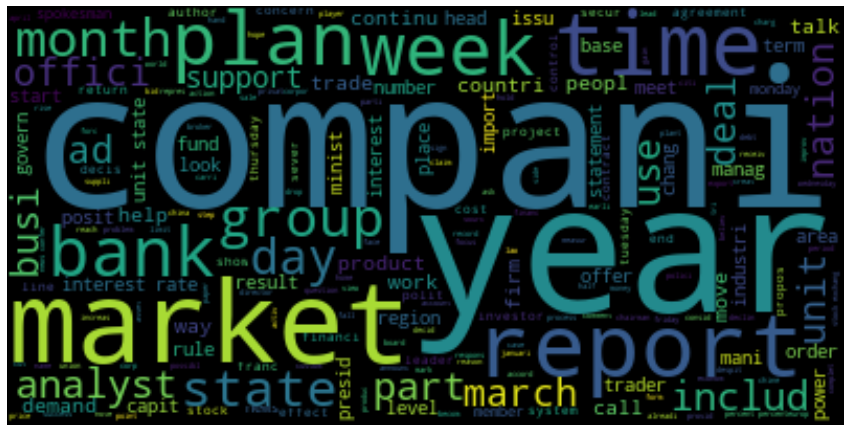

Shape of the vectorized data:  (48257, 10490)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from io import StringIO
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extraction of features using CountVectorizer method
def featureExtraction():
  
  # Data Cleaning and Pre-processing
  nounTokens=preprocessing()
  
  stringTokens=([' '.join((x)) for x in nounTokens]) # a list of all the Noun Tokens received from pre-processing.
  
  # Generating a WordCloud image to visualize the words based on their occurences.
  wordcloud = WordCloud().generate(''.join(str(e) for e in stringTokens)) 
  plt.figure(figsize=(15,15))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  
  # Performing CountVectorizer
  vectorizer=CountVectorizer(min_df=5, max_df = 0.40)
  X = vectorizer.fit_transform(stringTokens)
  print("Shape of the vectorized data: ",X.shape)

  #Creating a data frame with term frequency and inverse document frequency values. Appending the labels as well.
  vectorDataframe = pd.DataFrame(X.todense(), columns=list(vectorizer.get_feature_names()))
  vectorDataframe['biptopic']=data['biptopic'].values
  
  return vectorDataframe

# Calling the function and storing the returned DataFrame to the variable 'data'  
data=featureExtraction()

\

**A quick peak at the features extracted and the shape of the file.**

In [0]:
data

,aa,aaa,aalst,aar,aaron,ab,abandon,abat,abattoir,abb,abbey,abbrevi,abc,abdomin,abduct,abductor,abe,abel,aberdeen,abet,abid,abidjan,abil,abkhazia,abl,abm,abnorm,aboard,abod,abolish,abolit,aborigin,abort,abraham,abrog,abrupt,absenc,absent,absente,absolut,...,younger,youngster,youth,yr,yuan,yucatan,yugoslav,yugoslavia,yunnan,zabrz,zagreb,zair,zairean,zaman,zambia,zambian,zantac,zaragoza,zeal,zealand,zenith,zero,zhou,ziegler,zigzag,zimbabw,zimbabwean,zinc,zion,zionist,zip,zloti,zola,zone,zoo,zoom,zr,zulu,zurich,biptopic
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,"G15,GCAT"
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"G15,GCAT"
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"G15,GCAT"
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"G15,GCAT"
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"M13,M131,MCAT"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"E11,E12,E51,ECAT"
48253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M11
48254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M11
48255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C151



### **A function to evaluate the quality of the clusters.**

**A function to evaluate the quality of the clusters that were formed using K Means clustering. We are using Silhouette score and the Elbow method, both.**

- It takes the entire data and the range of K-values as input parameters, and helps us determine the best value of K based on the silhouette coefficient and the elbow method.
- Two graphs are plotted, one for the silhouette score and the other for the elbow method. Both the graphs are lineplots.
- We prioritize the results of silhouette score to gain the K value from this method, but also check the elbow method to compare and see if the results are close.
- This is how we're evaluating the quality of our clustering method, K Means.

**Reason:** We're using **Silhouette_Score** for the evaluation of our K Means clustering over the **Elbow Method** because Silhouette is an internal validation mechanism, optimized for K Means where as Elbow method is a manual decision making technique, which may not always be an accurate measure. Also, Elbow method was not giving us a deterministic elbow shape for our dataset, and so we couldn't use it to determine the K value.

In [0]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Calculates silhoutte score to select ideal number of K in KMeans clustering. Also visualized Elbow method graph to compare.
def evalCluster(data,start,end):
    
    # Setting the range in a variable
    range_n_clusters = list (range(start,end)) # set the range
    score={}
    distortions=[]
    
    for n_clusters in range_n_clusters: # perform clustering for each of the K values.
        
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=5)
        y = clusterer.fit_predict(data)

        message = "For n_clusters = {} The average silhouette_score is: {}"
        print(message.format(n_clusters, round(silhouette_score(data, y), 2))) # print the silhouette score and store them in a dict
        
        score[n_clusters]=(silhouette_score(data, y))
        distortions.append(clusterer.inertia_)
    
    # Plotting the silhouette scores on the graph
    plt.ylabel("Silouette")
    plt.xlabel("K - value")
    plt.title("Silouette for K-means cell's behaviour")
    ax1 = sns.lineplot(x=list(score.keys()), y=list(score.values()),label='Silouette')
    plt.show(ax1)

    # Plotting the Elbow on the graph
    ax2=plt.plot(range_n_clusters, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show(ax2)

    return int(max(score, key=score.get))

**Code bit to deduce the correct number of components using PCA**
- We're fitting PCA onto the data and plotting a graph to see the change in variance. We're considering the number of components for PCA when the variance is around 99%, to get an ideal value. 
- This will also help us reduce features that do not contribute much to the predictions, and consider the ones with the highest contributions.

**Reason:** We're using **PCA** over other methods like **LDA** because we're using multi-label classification. **LDA** does not work with multi-label data, and hence, **PCA** is the best option in our case.

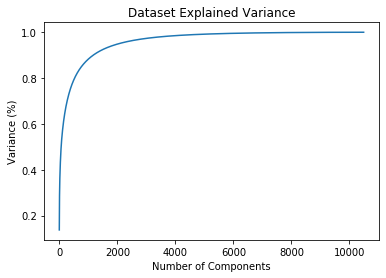

In [0]:
from sklearn.decomposition import PCA

pca = PCA().fit(data.drop(['biptopic'],axis=1).to_numpy())

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

\
**A function to binarize multi-label data**
- We're using MultiLabelBinarizer to binarize our records as each record has multiple Bip Topics in the format of a comma-separated string.
- The method returns the binarized labels.

In [0]:
# converting multiple labels into binary values 
from sklearn.preprocessing import MultiLabelBinarizer
def binarizeLabel(multilabels):
  label=pd.Series(multilabels)
  label = [set(i.split(',')) for i in label]
  lb = MultiLabelBinarizer()
  labels = lb.fit_transform(label)
  return labels

\
### **A function to cluster all the documents and assign a Cluster_ID to each document.**

**A method to form clusters using K Means clustering.**

- The K value will be the one achieved based on the best silhouette score, which is determined using the evalCluster() function.

- Additionally, we're using PCA to reduce the number of features and filter out features that won't contribute much to the clustering process.

- The function also plots a scatter plot displaying the clusters and the cluster centres.

**Reason:** We have used K Means over other clustering methods like DB-Scan because of the way the data points are arranged. They're closely arranged similar to a **Gaussian Mixture**. Hence, K Means proved to be a better clustering method for such data, and it also performs significantly well. 

We considered using **Expectation Maximization** as well because of the overlap in the data, but the method did not work well. Hence, we stuck with K Means.

However, K Means formed a couple of clusters with very few data points. Such clusters were insignificant for our predictions as they lack enough data for predictions. So, we ignored such clusters and went ahead with the ones which had close to 99% of the data in them.

For n_clusters = 3 The average silhouette_score is: 0.87
For n_clusters = 4 The average silhouette_score is: 0.87
For n_clusters = 5 The average silhouette_score is: 0.76
For n_clusters = 6 The average silhouette_score is: 0.35
For n_clusters = 7 The average silhouette_score is: 0.13
For n_clusters = 8 The average silhouette_score is: 0.64
For n_clusters = 9 The average silhouette_score is: 0.27


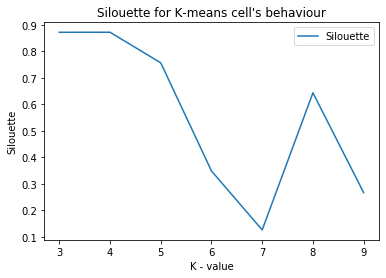

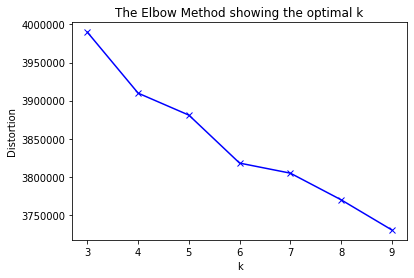

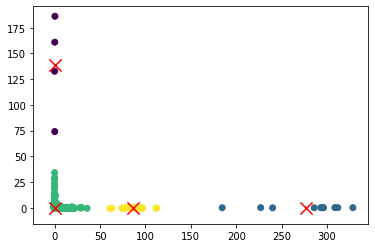

In [0]:
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score

def form_clusters(data):
  
  text=data.drop(['biptopic'], axis=1)

  #Principal component analysis to reduce dimensions.
  pca = PCA(n_components=3500)
  reduced_features = pca.fit_transform(text.to_numpy())
 
  n=evalCluster(reduced_features,3,10)
  clusterer = KMeans (n_clusters=n, init='k-means++', max_iter=1000, n_init=10, verbose=0)
  clust_pred = clusterer.fit_predict(reduced_features)
  
  # Reduce the cluster centers to 2D.
  reduced_cluster_centers = clusterer.cluster_centers_
  plt.scatter(reduced_features[:,0], reduced_features[:,1], c=clust_pred)
  plt.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:,1], marker='x', s=150, c='r')

  # Adding clusterID and Label to the dataframe.
  reduced_feats_df = pd.DataFrame(reduced_features, index = data.index, columns=None)
  reduced_feats_df["clusterID"] = clust_pred
  reduced_feats_df["biptopic"] = data['biptopic']

  return reduced_feats_df

data=form_clusters(data)

^^ 

**The above graph shows the distribution of data in the clusters using a scatter plot. As it can be seen, the data is divided in the form of a Guassian Mixture where except one cluster, all the other ones have very little data. We have considered a threshold of a minimum of 50 records for a cluster to be considered as a cluster with significant data, for further processing. And therefore, in the end, we were left with just one significant cluster.**



\
**Below is the sample data in one of the clusters formed**

- The clustering was performed with only the features sent to the K Means algorithms.
- The labels were assigned to the results after the clusters were distributed.
- If we notice, K Means successfully clustered various similar documents together. This can be confirmed by the same 'biptopic' values they have.

**This is another quick verification that the clusters are well-formed and are of good quality.**

In [0]:
data.loc[data['clusterID'] == 3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3462,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472,3473,3474,3475,3476,3477,3478,3479,3480,3481,3482,3483,3484,3485,3486,3487,3488,3489,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,clusterID,biptopic
2132,78.220546,-0.351245,0.290022,0.840117,-0.170744,0.529768,-1.069129,-2.324728,0.567815,-0.448265,0.243863,-0.918151,-1.976126,1.860892,0.227904,0.337924,-0.240018,0.107958,0.553311,1.047035,-0.068899,1.017320,0.471129,0.302802,-0.121902,-0.057131,0.937570,0.385974,-0.687232,-0.371563,0.396529,-0.646637,0.422677,-1.022709,0.796209,0.619349,-1.215230,-0.693748,0.054266,-0.790939,...,0.001588,-0.034694,0.027246,-0.025701,-0.000631,-0.003408,-0.016127,0.001827,0.019936,0.004136,-0.032774,0.014206,0.032243,-0.039345,-0.002615,0.010572,-0.041108,-0.006281,-0.053308,-0.011949,0.000837,0.005609,-0.007796,-0.030112,-0.022660,0.033361,-0.019196,0.017175,0.046927,-0.008288,-0.007875,-0.007364,-0.003638,0.026164,0.020725,0.039987,-0.007011,-0.003634,3,"E71,ECAT"
5098,96.518626,-0.348369,0.278118,0.702942,-0.170236,0.563695,-0.885956,-2.712111,0.175980,-0.498848,-0.892171,0.605128,-0.890681,2.781778,-0.526811,-0.451135,-0.171705,-0.346558,0.517076,0.397914,-0.449963,0.107051,0.348442,0.086764,-0.047933,-0.222956,0.983407,0.664494,-0.471819,-0.569301,0.171242,-0.846286,0.628115,-1.083121,0.809088,0.951110,-1.786995,-0.556351,-0.727776,-0.200620,...,-0.118490,0.113105,-0.107123,0.194054,0.049986,-0.031108,-0.088913,-0.144918,-0.059307,-0.186124,0.001799,-0.092322,-0.169823,-0.010776,0.081324,-0.136936,-0.055943,0.054293,0.072747,-0.116918,-0.083065,-0.114405,0.017029,0.013140,-0.104276,-0.043261,0.125715,-0.082483,-0.000277,-0.096496,-0.005543,-0.059986,-0.010438,-0.085941,-0.056196,-0.023949,-0.040467,-0.036823,3,"E71,ECAT"
7915,111.959850,-0.261244,0.201130,0.493031,-0.131367,0.657275,-0.687785,-2.875479,0.214217,-0.520713,-1.080194,0.755374,-0.630758,2.189355,-0.241045,-0.268888,-0.232521,-0.241357,0.493656,0.658144,-0.383002,0.239376,0.303474,0.171865,-0.162301,-0.273714,1.014180,0.733327,-0.522253,-0.638708,0.253833,-0.880002,0.905276,-1.302236,1.079759,0.906790,-2.223602,-0.798022,-1.264429,-0.018860,...,0.020942,0.009223,0.018345,0.014457,0.029395,0.038314,0.001337,0.009424,0.021573,0.019559,-0.023277,0.011903,0.058169,-0.019909,-0.036056,0.044232,-0.031135,-0.044045,-0.043196,-0.019848,-0.019459,0.007675,0.040779,-0.033187,-0.013639,0.014598,0.011288,0.032106,0.000973,0.014675,0.025023,0.003586,0.035858,0.007725,0.031391,0.020010,0.008773,0.013477,3,"E71,ECAT"
8257,93.309017,-0.394249,0.283215,0.689547,-0.172095,0.577738,-0.893147,-2.759573,0.164034,-0.501333,-0.849877,0.510058,-0.860932,2.478872,-0.395479,-0.402539,-0.185524,-0.270416,0.604012,0.399136,-0.418707,0.317958,0.389271,0.178536,0.008928,-0.209895,1.056389,0.599497,-0.465599,-0.560668,0.300525,-0.702627,0.645141,-1.187615,0.803856,0.993863,-1.569041,-0.593162,-0.623267,-0.379252,...,0.021185,-0.010516,0.008444,-0.017083,0.024279,0.041161,0.003969,0.037811,0.040940,0.038215,-0.029511,0.044711,0.095905,-0.040254,-0.020754,0.033204,-0.043242,-0.017679,-0.072123,-0.027239,-0.038918,0.038802,0.001192,-0.034248,-0.025807,0.005194,0.013076,0.035814,-0.016071,0.033543,0.023640,0.038135,0.059356,0.012417,0.049570,0.034194,-0.015549,-0.010295,3,"E71,ECAT"
11719,111.959865,-0.264710,0.199737,0.462574,-0.136350,0.667537,-0.697289,-2.916832,0.166799,-0.523660,-1.049387,0.745645,-0.624484,2.182330,-0.243887,-0.266527,-0.235956,-0.237575,0.487374,0.642729,-0.385741,0.253625,0.293768,0.198082,-0.132299,-0.281528,1.038553,0.713922,-0.496931,-0.643719,0.243945,-0.867122,0.887274,-1.255744,1.050038,0.914919,-2.252569,-0.790964,-1.267435,-0.023794,...,0.021874,0.009244,0.022318,0.015596,0.029794,0.038345,0.004925,0.008147,0.019734,0.021289,-0.024978,0.012455,0.056494,-0.021358,-0.038141,0.045448,-0.030936,-0.046567,-0.044215,-0.019380,-0.018362,0.010127,0.039454,-0.03107

**The below method *calculatescore()* measures the F1 score and returns it.**

In [0]:
from sklearn.metrics import roc_auc_score,make_scorer,auc,f1_score
f1_scorer = make_scorer(f1_score,average="macro")

In [0]:
# Calculate F1_score

def calculatescore(x,y):
    score=f1_score(x,y,average="macro")
    return score

**This method is to fit the model into a GridSearch CV and perform predictions.**
- It takes in the type of the model, and the test and train values as parameters, and fits them to GridSearchCV.

In [0]:
# Method to fit data to GridSearchCV and predict the data
def fitModel(cluster,model,x_train, x_val, y_train, y_val,param_grid):

  grid_clf_acc = GridSearchCV(model, param_grid = param_grid, cv=5,scoring=f1_scorer) # initializing GridSearchCV
  grid_clf_acc.fit(x_train, y_train) # Fitting the data
  y_pred=grid_clf_acc.predict(x_val) 
  x_pred=grid_clf_acc.predict(x_train) 

  # Calculate the Training F1 score
  trainscore=calculatescore(y_train, x_pred)

  # Calculate the Testing F1 score
  testScore=calculatescore(y_val, y_pred)

  print('Training F1 score for Cluster {} : {:.4f} %'.format(cluster,(trainscore)*100))
  print('Testing F1 score for Cluster {} : {:.4f} %'.format(cluster,(testScore)*100))

  return trainscore, testScore

\
**A method to split data using K-fold cross validation.**
- Data is split based using K fold cross validation.
- Data is being split in 5 folds as the data size is small and for each score, the F1_score is being calculated to evaluate the split.
- The model is fit using the 'fitModel' method defined above, and is transfromed based on the type of classifying model passed.
- All the evaluation scores are stored in a list and returned by the function.

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import numpy
from sklearn.preprocessing import MultiLabelBinarizer

# Splitting the data into training and testing sets using k-fold cross validation
def split_data(cluster,X,y,model,param_grid={}):

  cv_scores = []
  cv = KFold(n_splits=5, random_state=42, shuffle=True)
  
  for train_index, test_index in cv.split(X):
    x_train, x_val, y_train, y_val = X[train_index], X[test_index], y[train_index], y[test_index]
    train,test=fitModel(cluster,model,x_train, x_val, y_train, y_val,param_grid)
    cv_scores.append({"train":train,"test":test})
  
  return cv_scores

\
***plotboxplot()* methods takes in the K Fold training and testing scores and plots a box plot for visualization.**

In [0]:
# Box plot for training and testing scores from 5-fold cross validation
def plotboxplot(kfoldScores):

  a=pd.DataFrame(kfoldScores)
  sns.boxplot(y='value', x='cluster', 
                  data=a, 
                  palette=["m","g"],
                  hue='variable')

\
**Mann-Whitney U Test:** We're performing Mann Whitney U test to find the distribution of results of the K Fold cross validation, for each cluster. The method *MWtest()* performs this operations by considering the cluster #, Training and Testing data.

**Reason:** We're using **Mann-Whitney** instead of **T-test** because we have a low number of folds (K-fold = 5) and Mann-Whitney is a better evaluation metric for less number of folds in Cross Validation.

In [0]:
# Mann Whitney Test to observe the distribution of data
from scipy.stats import mannwhitneyu
def MWtest(cluster,train,test):
  
  stat, p = mannwhitneyu(train,test)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  
  # Interpret
  alpha = 0.05
  
  # If the distribution is same, mean of respective set of scores is considered as the final score
  if p > alpha:
    train=np.mean(train, dtype=np.float64)
    test=np.mean(test, dtype=np.float64)
    print('Cluster {} has same distribution on x and y'.format(cluster))

  # If the distribution is different, median of respective set of scores is considered asfinal score
  else:
    train=np.median(train)
    test=np.median(test)
    print('Cluster {} has different distribution on x and y'.format(cluster))

  return train,test
        


### **Performing classification on the clusters' data using OnevsRestClassifier.**

**The below code will perform data splitting for each cluster and build a classifier for it.**
- We're using Logistic Regression with One versus Rest Classifier using GridSearch CV for each of the cluster, as opposed to building a different classifier for each cluster, because using the same classifiers will help us compare the clusters accurately and evaluate the model with more confidence.
- As different types of classifiers use different working methodologies, it wouldn't be just to compare different models built on different clusters, we feel.
- A box plot is being plotted based on the evaluation metrics.

**Note:** We're only considering the clusters which have significant amount of data. Clusters with very few records will not contribute in building a good model, so we're ignoring those clusters. Those clusters, built using K Means, might just be clusters having data of the outliers and insignificant.





Training F1 score for Cluster 1 : 81.0990%
Testing F1 score for Cluster 1 : 36.4315%
Training F1 score for Cluster 1 : 77.4615%
Testing F1 score for Cluster 1 : 43.9215%
Training F1 score for Cluster 1 : 85.5731%
Testing F1 score for Cluster 1 : 38.4305%
Training F1 score for Cluster 1 : 75.5366%
Testing F1 score for Cluster 1 : 40.6624%
Training F1 score for Cluster 1 : 71.3371%
Testing F1 score for Cluster 1 : 41.6109%
Statistics=0.000, p=0.006
Cluster 1 has different distribution on x and y


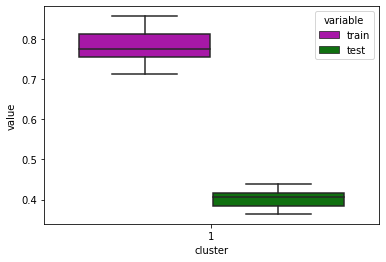

In [11]:
# For each cluster created, splitting the data into into training and testing sets using cross validation and evaluate the clusters with the help of classifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import numpy as np; np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

# Group the clusters by using cluster ID
clusterGroup=data.groupby('clusterID')
compareScores=[]

def tradClassifier():
  kfoldScores=[]
  label = pd.DataFrame()

  for cluster,value in clusterGroup:
    # Number of samples in the cluster must be greater than 50.
    if(value.shape[0]>50):

      label = binarizeLabel(value["biptopic"].astype(str).values) # Binarizing the labels

      # Loading only the features and resetting the dataframe's index
      clusterdata=value.drop(['clusterID','biptopic'], axis=1) 
      clusterdata.reset_index(inplace=True,drop=True)

      # Converting to dataframe to matrix, to get rid of index values
      clusterdata=csr_matrix(clusterdata.values)
      
      # OnevsRestClassifier using Logistic Regression model.
      clf = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
      param_grid = {
      }
      
      # Splitting data using k-fold and training the model with the data
      result=split_data(cluster,clusterdata,label,clf,param_grid)

      train=[]
      test=[]

      # For each result achieved
      for i in result:
        
        train.append(i["train"])
        test.append(i["test"])
        kfoldScores.append({"cluster":cluster,"variable":"train","value":i["train"]})
        kfoldScores.append({"cluster":cluster,"variable":"test","value":i["test"]})
      
      # Performing Mann-Whitney on the Training and Testing data
      train,test=MWtest(cluster,train,test)
      
      # Appending Model Name, and results to 'compareScores' list
      compareScores.append({"model":"TraditionalClassifier","cluster":cluster,"train":train,"test":test})

  # Plotting a Box Plot on the scores of the K-Fold splits    
  plotboxplot(kfoldScores)
    

# Calling the function    
tradClassifier()  

^^
The above output shows the **Training and Testing F1 Score** for each fold of each cluster. Since **K-Fold = 5**, we have scores 5 times. 


### Enhancing the feature extraction using a deep neural network, and improving the classification.**

- We're building two models for this process:
 - **Model 1:** Using Auto-encoders artificial neural networks.
 - **Model 2:** Using deep learning technique - Convolutional Neural Networks.

- After building the models, we perform a comparison between both the deep learning technique models, and show the results.

**NOTE:** In *both models*, feature extraction is done within the model itself, before the model performs classification. Data is directly fed into the model, which has layers that will first enhance the feature extraction and then classify the data. We are following this methodology instead of performing feature enhancement and classification, separately, because thought our method will be optimal and efficient.



**Importing all the required libraries from Keras, TenserFlow and SKLearn.**

In [0]:
from tensorflow import keras
from keras.preprocessing import sequence
from keras.preprocessing import text
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, Flatten
from keras.preprocessing import text
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv1D,Conv2D,MaxPooling1D,MaxPooling2D,UpSampling1D,UpSampling2D,Concatenate,AveragePooling1D,GlobalAveragePooling1D,GlobalAveragePooling2D,BatchNormalization,Concatenate,MaxPool2D
from keras.layers.merge import concatenate
from sklearn.metrics import mean_squared_error as mse
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import AveragePooling2D,MaxPooling2D


**calc_lossAcc**: This function calculates the loss and accuracy of the model and returns those values.

In [0]:
# Calculating accuracy and loss of a model
def calc_lossAcc(description,cluster,model,x,y):
  loss, accuracy = model.evaluate(x, y, verbose=False)
  display(HTML("<h3>"+description+" {}: {:.2f}%, {}</h3>".format(cluster,accuracy*100,loss)))
  return loss, accuracy



**evlPlot**: This function plots the variations in the Training and Testing Accuracies across Epochs.

In [0]:
# Plot for variations in training and testing accuracies against the number of Epochs.
def evlPlot(history):

  plt.plot(history.history['acc'], label='acc')
  plt.plot(history.history['val_acc'], label = 'val_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')
  plt.show()



### **Model 1: Feature extraction and classification using regular Autoencoders.**


**createModel1**: This function uses **Autoencoders** for enhancing the feature selection and builds a classifier.
- A sequential autoencoder is used.
- Each cluster's data is encoded and decoded as a part of autoencoding.
- The summary of the autoencoded layers is printed on the console for better understanding of the layers and the dimensional selection.
- The following are used during compilation:
 - Optimizer: Adam (A good optimizer for neural networks)
 - Loss Function: Binary Crossentropy for Encoder and Categorical Crossentropy for Decoder (Good loss functions when dealing with multi-label classification problems)
 - Evaluation Metric: Accuracy (A standard evaluation metric for classification)

As the data is huge, we're running the neural network using 10 Epocs.

The function returns the model.


In [0]:
# A simple autoencoder model with encoder and decoder with 3 layers

def createModel1(cluster,init,x_train, x_val, y_train, y_val,outputdim):
  
  # For better, readable output display
  display(HTML("<h1>Model 1</h1>"))
  
  autoencoder_model = Sequential() # Using Sequential model
  EMBEDDING_DIM=init["EMBEDDING_DIM"] # Initiating Embedding object
  epochs=init["epochs"] # Initiating Epochs object
  batch_size=init["batch_size"] # Initiating Batch Size object

  # Encoder Layers
  # Three Dense layers. Each of the layers takes in an activation function and a kernel, and outputs to the next layer.
  autoencoder_model.add(Dense(4 * EMBEDDING_DIM, input_shape=(x_train.shape[1],), activation='relu')) # Input layer
  autoencoder_model.add(Dense(2 * EMBEDDING_DIM, activation='tanh'))
  autoencoder_model.add(Dense(outputdim, activation='sigmoid')) 

  # Decoder Layers
  # Three layers again where the last one outputs the decoded data for loss calculation.
  autoencoder_model.add(Dense(2 * EMBEDDING_DIM, activation='sigmoid')) # 
  autoencoder_model.add(Dense(4 * EMBEDDING_DIM, activation='tanh')) # 
  autoencoder_model.add(Dense(x_train.shape[1], activation='sigmoid')) # 

  autoencoder_model.summary()

  # Compile method configures the model by adding a suitable optimizer, loss function, evaluation metric etc.
  autoencoder_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["accuracy"])
  
  autoencoder_model.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=batch_size,validation_data=(x_val, x_val)
                  )
  # Decoder evaluation
  calc_lossAcc("Accuracy of decoded data",cluster,autoencoder_model,x_train,x_train)

  # Storing encoder layers to send to and build a classifier.
  inputs = Input(shape=(x_train.shape[1],))
  encoder_layer1 = autoencoder_model.layers[0]
  encoder_layer2 = autoencoder_model.layers[1]
  encoder_layer3 = autoencoder_model.layers[2]
  encoder = Model(inputs, encoder_layer3(encoder_layer2(encoder_layer1(inputs))))

  encoder.summary()
  encoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])
  
  return encoder

\

### **Method 2: Feature extraction and classification using Convolutional Neural Networks [CNN].**

**createModel2**: This function uses **Convolutional Neural Networks** for enhancing the feature selection and builds a classifier.

- It consists of multiple convolutional layers like filters, batch normalizations and pooling.
- We're using DroupOut technique to regularize and to avoid over-fitting the model.
- We're using 'Sigmoid' as the classifying activation function for our final, output layer.
- The following parameters are used during compilation:
 - Optimizer: Hyper-parameterized 'Adam' (A good optimizer for neural networks)
 - Loss Function: Binary Crossentropy (One of the best loss functions when dealing with multi-label classification problems)
 - Evaluation Metric: Accuracy (A standard evaluation metric for classification)

The function prints the summary of the neural network and returns the model.

**Reason:** We're using the **'Sigmoid' for the output classifier, instead of Softmax** because we are performing multi-class, multi-label classification. Sigmoid provides independent probabilities which is good for multi-class, multi-label, where as Softmax provides probability distribution around classes, which will result in incorrect classification [23].

In [0]:
#Convolutional neural network model withmultiple layers
def createModel2(cluster,init,x_train, x_val, y_train, y_val,outputdim):
  
  # For better, readable output display
  display(HTML("<h1>Model 2</h1>"))

  MAX_SEQUENCE_LENGTH=init["MAX_SEQUENCE_LENGTH"] # Initiating Max Sequence Length object
  EMBEDDING_DIM=init["EMBEDDING_DIM"] # Initiating Embedding object
  batch_size=init["batch_size"] # Initiating Batch Size object
  
  # Initiating variables with data that will be used in the CNN process.
  filter_sizes = [3,4,5]
  num_filters = 512
  embedding_dim = 100
  
  # Dropout probability
  drop = 0.5
  word_index=data.shape[1]

  # embedding layer to create word embeddings
  embedding_layer = Embedding(word_index,
                              EMBEDDING_DIM,
                              input_length=MAX_SEQUENCE_LENGTH,
                              trainable=False)


  # Multi-layered CNN architecture.

  # Input layer
  inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  
  # Creating embedding layer with unique words
  embedding = embedding_layer(inputs)

  # Converting data to 4-dimensions
  reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
  

  # Three sets of layers are passed over the reshape layer, and are then flattened.

  # Each set contains a Convolutional 2D layer, a Batch Normalizing layer and a Pooling layer (Average pooling, here)
  conv1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), padding='valid', activation='relu')(reshape)
  conv1 = BatchNormalization()(conv1)
  pool1 = AveragePooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv1)

  conv2 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), padding='valid', activation='relu')(reshape)
  conv_1 = BatchNormalization()(conv2)
  pool2 = AveragePooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv2)

  conv3 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), padding='valid', activation='relu')(reshape)
  conv3 = BatchNormalization()(conv3)
  pool3 = AveragePooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv3)

  # Flattening output of the above three sets of data.
  flat1 = Flatten()(pool1)
  flat2 = Flatten()(pool2)
  flat3 = Flatten()(pool3)

  # Concatenating the flattened layers.
  concatenated_tensor = Concatenate(axis=1)([flat1, flat2, flat3])

  # Dropping out to avoid over-fitting.
  dropout = Dropout(drop)(concatenated_tensor)
  output = Dense(units=outputdim, activation='sigmoid')(dropout)

  model = Model(inputs=inputs, outputs=output)
  adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

  # Compiling the classifier with a Hyper-parameterized optimizer.
  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=["accuracy"])
  model.summary()

  return model




### **Building both Model 1 and Model 2 for each of the significant clusters and *comparing* the results.**

- We're running a loop for each of the clusters with significant amount of data.
- Each of the identified clusters are passed to the functions model1 and model2 to build two separate models, as mentioned in the above cells.
- A comparison between the models' score is performed to find which one is better.




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               1400400   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_3 (Dense)              (None, 102)               20502     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20600     
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 3500)              1403500   
Total params: 3,005,602
Trainable params: 3,005,602
Non-trainable params: 0
_________________________________________

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               1400400   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_3 (Dense)              (None, 102)               20502     
Total params: 1,501,102
Trainable params: 1,501,102
Non-trainable params: 0
_________________________________________________________________
Train on 32308 samples, validate on 15914 samples
Epoch 1/50
32308/32308 [==============================] - 5s 148us/step - loss: 0.2325 - acc: 0.9422 - val_loss: 0.0875 - val_acc: 0.9748
Epoch 2/50
32308/32308 [==============================] - 4

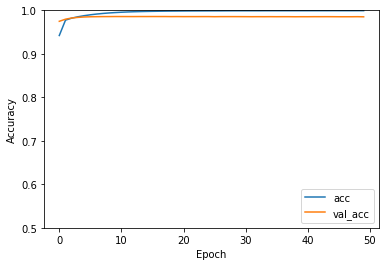





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3500)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 3500, 100)    350200      input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3500, 100, 1) 0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3498, 1, 512) 154112      reshape

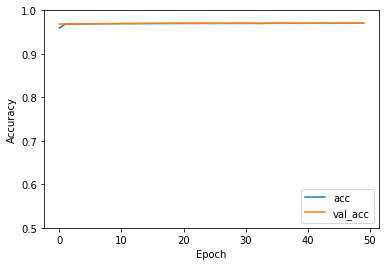

In [0]:
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

# Looping through each cluster and calling both Models onto each cluster.
for cluster,value in clusterGroup:

  # We're only considering clusters with significant amount of data.
  if(value.shape[0]>50):

    # Tidying the output.
    display(HTML("<h1>Feature Extraction and classification for cluster "+str(cluster)+"</h1>"))

    labels=binarizeLabel(value["biptopic"].astype(str).values) # binarizing the labels

    # Setting dataCluster variable with the features and converting it to a compressed sparse row matrix.
    dataCluster=value.drop(['clusterID','biptopic'], axis=1)
    dataCluster.reset_index(inplace=True,drop=True)
    dataCluster=csr_matrix(dataCluster.values)

    epochs=50 # Iterations
    batch_size = 50 # Batch Size

    # Storing required information in a Dict.
    init={}
    init["MAX_SEQUENCE_LENGTH"]=dataCluster.shape[1]
    init["EMBEDDING_DIM"]=100
    init["word_index"]=dataCluster.shape[1]
    init["batch_size"]=batch_size
    init["epochs"]=epochs

    # Splitting data using test train split
    x_train, x_val, y_train, y_val = train_test_split(dataCluster, labels, test_size=0.33, random_state=42)
   
# Running Autoencoder model [Model 1]
    
    model1=createModel1(cluster,init,x_train, x_val, y_train, y_val,labels.shape[1])
    history1=model1.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,validation_data=(x_val, y_val)
                    )
    evlPlot(history1)

    # Train and Test Scores
    trainscore1=calc_lossAcc("Training Accuracy and loss for cluster",cluster,model1,x_train,y_train)
    testscore1=calc_lossAcc("Testing Accuracy and loss for cluster",cluster,model1,x_val,y_val)

    # Storing results in a list.
    compareScores.append({"cluster":cluster,"model":"NNmodel1","train":trainscore1[1],"test":testscore1[1]})
    display(HTML("</br></br>"))

# Running Convolutional Neural Network model [Model 2]
    
    model2=createModel2(cluster,init,x_train, x_val, y_train, y_val,labels.shape[1])
    history2=model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val))
    evlPlot(history2)

    # Train and Test Scores
    trainscore2=calc_lossAcc("Training Accuracy and loss for cluster",cluster,model2,x_train,y_train)
    testscore2=calc_lossAcc("Testing Accuracy and loss for cluster",cluster,model2,x_val,y_val)
    
    # Storing results in a list.
    compareScores.append({"cluster":cluster,"model":"NNmodel2","train":trainscore2[1],"test":testscore2[1]})

\
**A simple dataframe showing the testing and training scores of all three models we have built:**
1. Traditional Classifier: OnevsRest Classifier using Logistic Regression.
2. Deep Neural Network: Autoencoder model.
3. Deep Neural Network: Convolutional Neural Network.

In [0]:
# Loading the scores in a Data Frame to display.

df1=pd.DataFrame()
df=df1.append(compareScores)
df

,cluster,model,train,test
0,1,Traditional Classifier,0.774615,0.406624
1,1,Autoencoder,0.999323,0.985179
2,1,Convolutional Neural network,0.970805,0.970485


\
**Plotting bar graphs showing the different models and how they performed.**

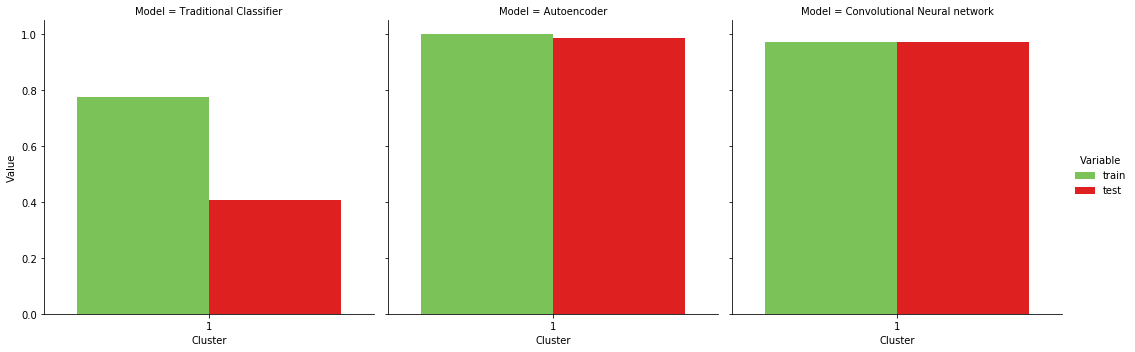

In [0]:
# Plotting all the results using a Bar graph for comparison.

models = df.melt(id_vars=['cluster','model']).rename(columns=str.title)
g = sns.catplot(data=models, x='Cluster', y='Value', hue='Variable', col='Model', kind='bar',palette=['#75d446','red'])


### **Comparison Results:**

- As it can be seen, the Traditional Classifier performed relatively poorly with Training score around 77% and the Testing score around 40%.
- The Neural Network models have performed excellently well, with scores ranging close to 99%.
- The traditional classifier also consumed a lot of time for processing. Deep learning methods reduce the features and take only the significant features into account, and thereby, were relatively much quicker.

#### **We have certainly improved our classification methodology using Deep Learning methods.**

### **Conclusion**

- By comparison, Deep Learning methods worked much better than traditional ML models for text classification, especially for this particular problem.
- Deep learning models also consume less computational time as they perform dimensionality reduction by choosing the most important features only.





### **Other Observations**

**1. Performing K Means clustering using TFIDF**

**Observation:** There was a very high overlap in the clusters, which didn't make sensible clusters. So we dropped the idea of using TFIDF, and instead used Bag of Words.

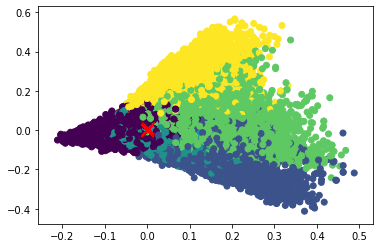

**2. Performing K Means clustering using Bag of Words, without performing PCA (Dimensionality reduction)**

**Observation:** Without performing PCA, there is a significant amount of overlap in the clusters which is not desired.

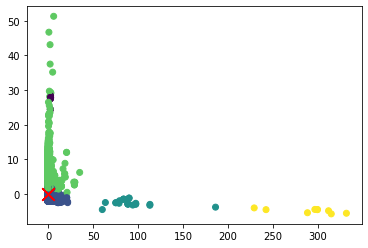


## **References:**


[1]Liang, Hong et al. “Text feature extraction based on deep learning: a review.” EURASIP journal on wireless communications and networking vol. 2017,1 (2017): 211. doi:10.1186/s13638-017-0993-1
\
\
[2]Maggipinto, M., Masiero, C., Beghi, A., & Susto, G. A. (2018). A Convolutional Autoencoder Approach for Feature Extraction in Virtual Metrology: Paper ID 259. Procedia Manufacturing, 17, 126-133.
\
\
[3]"Keras Conv1D: Working with 1D Convolutional Neural Networks in Keras - MissingLink.ai", MissingLink.ai. [Online]. Available: https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/.[Accessed: 04- Dec- 2019]. 
\
\
[4]D. Möller, "Keras input explanation: input_shape, units, batch_size, dim, etc", Stack Overflow, 2017. [Online]. Available: https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc. [Accessed: 04- Dec- 2019].
\
\
[5]A. Sharma, "Autoencoder as a Classifier", DataCamp Community, 2018. [Online]. Available: https://www.datacamp.com/community/tutorials/autoencoder-classifier-python. [Accessed: 04- Dec- 2019].
\
\
[6]"GINK03/keras-cnn-text-classify", GitHub, 2017. [Online]. Available: https://github.com/GINK03/keras-cnn-text-classify/blob/master/keras2-text-tag-predictor/cnn_text_classify.py. [Accessed: 04- Dec- 2019].
\
\
[7]J. B, "Clustering documents with TFIDF and KMeans | Kaggle", Kaggle.com, 2018. [Online]. Available: https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans. [Accessed: 04- Dec- 2019].
\
\
[8]A. Sharma, "Keras Autoencoders: Beginner Tutorial", DataCamp Community, 2018. [Online]. Available: https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial. [Accessed: 04- Dec- 2019].
\
\
[9]S. Kamal, "Text Classification With Python and Keras | Kaggle", Kaggle.com, 2018. [Online]. Available: https://www.kaggle.com/sanikamal/text-classification-with-python-and-keras. [Accessed: 04- Dec- 2019].
\
\
[10]"Convolutional Neural Network (CNN)  |  TensorFlow Core", TensorFlow. [Online]. Available: https://www.tensorflow.org/tutorials/images/cnn. [Accessed: 04- Dec- 2019].
\
\
[11]"Using the Keras Flatten Operation in CNN Models with Code Examples - MissingLink.ai", MissingLink.ai. [Online]. Available: https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/. [Accessed: 04- Dec- 2019].
\
\
[12]S. Saikia, "Building a Convolutional Autoencoder using Keras using Conv2DTranspose", Medium, 2019. [Online]. Available: https://medium.com/analytics-vidhya/building-a-convolutional-autoencoder-using-keras-using-conv2dtranspose-ca403c8d144e. [Accessed: 04- Dec- 2019].
\
\
[13]"lukas/ml-class", GitHub. [Online]. Available: https://github.com/lukas/ml-class. [Accessed: 04- Dec- 2019].
\
\
[14]L. Beiwald, "YouTube", Youtube.com, 2018. [Online]. Available: https://www.youtube.com/watch?v=8YsZXTpFRO0. [Accessed: 04- Dec- 2019].
\
\
[15]"Guide to the Sequential model - Keras Documentation", Keras.io. [Online]. Available: https://keras.io/getting-started/sequential-model-guide/. [Accessed: 04- Dec- 2019].
\
\
[16]N. Janakiev, "Practical Text Classification With Python and Keras – Real Python", Realpython.com. [Online]. Available: https://realpython.com/python-keras-text-classification/. [Accessed: 04- Dec- 2019].
\
\
[17]J. Knows, "autoencoder for features selection", Data Science Stack Exchange, 2018. [Online]. Available: https://datascience.stackexchange.com/questions/33338/autoencoder-for-features-selection/33342. [Accessed: 04- Dec- 2019].
\
\
[18]D. Mwiti, "Using a Keras Embedding Layer to Handle Text Data", Medium, 2019. [Online]. Available: https://heartbeat.fritz.ai/using-a-keras-embedding-layer-to-handle-text-data-2c88dc019600. [Accessed: 04- Dec- 2019].
\
\
[19]"Negative dimension size caused by subtracting 3 from 1 for 'conv2d_2/convolution'", Stack Overflow, 2017. [Online]. Available: https://stackoverflow.com/questions/45645276/negative-dimension-size-caused-by-subtracting-3-from-1-for-conv2d-2-convolution/45647715#45647715. [Accessed: 04- Dec- 2019].
\
\
[20]J. Brownlee, "How to Choose Loss Functions When Training Deep Learning Neural Networks", Machine Learning Mastery, 2019. [Online]. Available: https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/. [Accessed: 04- Dec- 2019].
\
\
[21]E. Plog, "AUC ROC Curve Scoring Function for Multi-class Classification", Medium, 2018. [Online]. Available: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659. [Accessed: 04- Dec- 2019].
\
\
[22]K. Nooney, "Deep dive into multi-label classification..! (With detailed Case Study)", Medium, 2018. [Online]. Available: https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff. [Accessed: 11- Dec- 2019].
\
\
[23]"What loss function for multi-class, multi-label classification tasks in neural networks?", Cross Validated, 2017. [Online]. Available: https://stats.stackexchange.com/questions/207794/what-loss-function-for-multi-class-multi-label-classification-tasks-in-neural-n. [Accessed: 11- Dec- 2019].